In [19]:
# +------------+
#  SUUUUUUUUUUU
# +------------+

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import _california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import *
from sklearn.ensemble import *

from tqdm import tqdm

#Settings

plt.style.use('dark_background')

#End Settings

"""
- MedInc        median income in block group
- HouseAge      median house age in block group
- AveRooms      average number of rooms per household
- AveBedrms     average number of bedrooms per household
- Population    block group population
- AveOccup      average number of household members
- Latitude      block group latitude
- Longitude     block group longitude
- MedHouseVal
"""

df = _california_housing.fetch_california_housing(as_frame=True).frame

<AxesSubplot: >

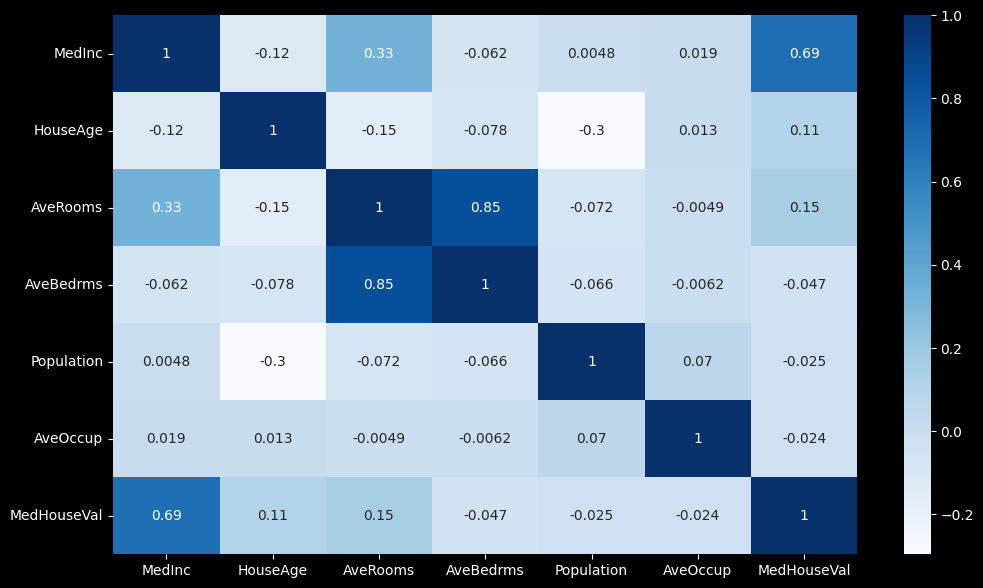

In [3]:
#Heatmap

data = df.drop(columns=["Latitude", "Longitude"])
plt.figure(figsize=(12,7))
sns.heatmap(data.corr(),cbar=True,annot=True,cmap='Blues')

In [23]:
#Traitement des données

#Definition de la target
target_name = "MedHouseVal"
target = df[target_name]

#Colonnes exclues pour le test
colsToDrop = [
    target_name, 
    "Population", 
    "AveOccup", 
    "AveBedrms", 
    "HouseAge", 
    "AveRooms"
    ]
data = df.drop(columns=colsToDrop)

#Modeles a tester
models = [
    AdaBoostRegressor(), 
    BaggingRegressor(n_jobs=-1), 
    ExtraTreesRegressor(n_jobs=-1), 
    GradientBoostingRegressor(), 
    RandomForestRegressor(n_jobs=-1), 
    HistGradientBoostingRegressor()
    ]

linear_models = [
    LinearRegression(),
    Ridge(),
    RidgeCV(),
    SGDRegressor(),
    Lasso(),
]

#La fonction
def TestModel(models, attemps):

    display_df = pd.DataFrame(columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])

    for model in models:

        #Affichage
        model_name = model.__class__.__name__
        print(f"{model_name}")

        #Initialisation des listes
        score_results = []
        time_results = []
        
        for i in tqdm(range(attemps)):

            start = time.time()

            #Split et Fit
            data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.25, random_state=np.random.randint(0,100))
            model.fit(data_train, target_train)

            #Calcul du score
            score = model.score(data_test, target_test)

            #Sauvegarde du resultat
            score_results.append(score)
            time_results.append(time.time() - start)

            #Affichage
            #print(i/attemps,"%","completed")

        #Affichage
        avg_score = round(np.average(score_results) * 100, 3)
        max_score = round(np.max(score_results) * 100, 3)
        avg_time = round(np.average(time_results), 3)

        new_row = pd.DataFrame([[model_name, avg_score, max_score, avg_time]], columns=["ModelName","AvgScore","MaxScore","AvgExecTime"])
        display_df = pd.concat([display_df, new_row])

    print(f"-"*64, "\nResults :\n", display_df.to_string(index=False))

#Call de la fonction
TestModel(models,10)
TestModel(linear_models,10)


AdaBoostRegressor


100%|██████████| 10/10 [00:02<00:00,  3.41it/s]


BaggingRegressor


100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


ExtraTreesRegressor


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]


GradientBoostingRegressor


100%|██████████| 10/10 [00:09<00:00,  1.01it/s]


RandomForestRegressor


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


HistGradientBoostingRegressor


100%|██████████| 10/10 [00:12<00:00,  1.29s/it]


---------------------------------------------------------------- 
Results :
                     ModelName  AvgScore  MaxScore  AvgExecTime
            AdaBoostRegressor    37.466    46.705        0.293
             BaggingRegressor    81.185    82.047        0.229
          ExtraTreesRegressor    81.197    81.916        0.407
    GradientBoostingRegressor    76.377    77.280        0.989
        RandomForestRegressor    82.495    83.168        0.578
HistGradientBoostingRegressor    81.883    82.898        1.287
LinearRegression


100%|██████████| 10/10 [00:00<00:00, 90.38it/s]


Ridge


100%|██████████| 10/10 [00:00<00:00, 153.44it/s]


RidgeCV


100%|██████████| 10/10 [00:00<00:00, 123.89it/s]


SGDRegressor


100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


Lasso


100%|██████████| 10/10 [00:00<00:00, 102.89it/s]

---------------------------------------------------------------- 
Results :
        ModelName      AvgScore      MaxScore  AvgExecTime
LinearRegression  5.844500e+01  6.011300e+01        0.011
           Ridge  5.848500e+01  5.889000e+01        0.007
         RidgeCV  5.844600e+01  5.915200e+01        0.008
    SGDRegressor -2.158162e+26 -9.460010e+25        0.420
           Lasso  2.647000e+01  2.692900e+01        0.010
